<a href="https://colab.research.google.com/github/threegenie/News_topic_classifying/blob/main/news_topic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **뉴스 토픽 분류 AI 경진대회**
한국어 뉴스 헤드라인을 이용하여, 뉴스의 주제를 분류하는 알고리즘 개발


0 : IT과학 / 1 : 경제 / 2 : 사회 / 3 : 생활문화 / 4 : 세계 / 5 : 스포츠 / 6 : 정치

In [1]:
%%capture
! pip install konlpy

In [2]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [4]:
df = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [5]:
df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [6]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [7]:
df['title'] = df['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['title'].replace('', np.nan, inplace=True)
df.head()

,index,title,topic_idx
0,0,인천핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,클린턴 측근기업 특수관계 조명공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [8]:
test['title'] = test['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['title'].replace('', np.nan, inplace=True)
test.head()

,index,title
0,45654,유튜브 내달 일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져남부지방 옅은 황사
2,45656,내년부터 국가 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 권 출간


#### 토큰화 - Okt 사용

In [9]:
from konlpy.tag import Okt
okt = Okt()

In [10]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [11]:
df['tokenized'] = df['title'].apply(okt.morphs)
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [12]:
test['tokenized'] = test['title'].apply(okt.morphs)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#### 훈련, 테스트셋 분리

In [13]:
from sklearn.model_selection import train_test_split

train = df['tokenized']
target = df['topic_idx']

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size = 0.1, random_state = 11)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((41088,), (4566,), (41088,), (4566,))

In [14]:
X_test = test['tokenized']

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31196
등장 빈도가 1번 이하인 희귀 단어의 수: 13164
단어 집합에서 희귀 단어의 비율: 42.19771765610976
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.629625953314474


In [17]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18034


In [18]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)
X_test= tokenizer.texts_to_sequences(X_test)

기사의 최대 길이 : 17
기사의 평균 길이 : 8.826956775700934


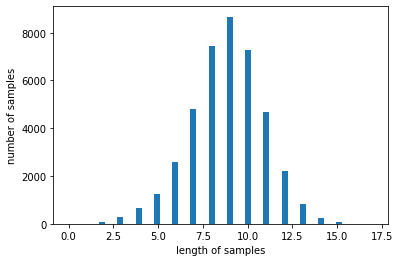

In [19]:
print('기사의 최대 길이 :',max(len(l) for l in X_train))
print('기사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#### LSTM 모델을 이용한 기사 분석

In [21]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Bidirectional

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100))
model_lstm.add(LSTM(100)) #Bidirectional drop
model_lstm.add(Dense(1, activation='relu')) #activation = sigmoid -> relu

In [22]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1803400   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,883,901
Trainable params: 1,883,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
es_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_lstm = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [24]:
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model_lstm.fit(X_train, y_train, epochs=15, callbacks=[es_lstm, mc_lstm], batch_size=60, validation_split=0.2)

Epoch 1/15
548/548 [==============================] - 58s 100ms/step - loss: -32.7097 - acc: 0.1354 - val_loss: -32.8050 - val_acc: 0.1377

Epoch 00001: val_acc improved from -inf to 0.13775, saving model to best_model.h5
Epoch 2/15
548/548 [==============================] - 54s 99ms/step - loss: -33.0444 - acc: 0.1356 - val_loss: -32.8050 - val_acc: 0.1377

Epoch 00002: val_acc did not improve from 0.13775
Epoch 3/15
548/548 [==============================] - 54s 99ms/step - loss: -33.0444 - acc: 0.1356 - val_loss: -32.8050 - val_acc: 0.1377

Epoch 00003: val_acc did not improve from 0.13775
Epoch 4/15
548/548 [==============================] - 54s 98ms/step - loss: -33.0444 - acc: 0.1356 - val_loss: -32.8050 - val_acc: 0.1377

Epoch 00004: val_acc did not improve from 0.13775
Epoch 5/15
548/548 [==============================] - 54s 98ms/step - loss: -33.0444 - acc: 0.1356 - val_loss: -32.8050 - val_acc: 0.1377

Epoch 00005: val_acc did not improve from 0.13775
Epoch 00005: early sto

In [25]:
y_pred = model_lstm.predict(X_val)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [28]:
accuracy_score(y_val, y_pred)

ValueError: ignored

In [29]:
print(classification_report(y_val, y_pred))

ValueError: ignored

#### 제출 파일 

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
pred = model_lstm.predict(X_test)

In [ ]:
submission['topic_idx'] = pred
submission.head()